### 드라이브 가져오기 : 데이터 셋 colaboratory로 불러오기 위함

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Required Library

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from scipy.io import loadmat
import os
import cv2

Using TensorFlow backend.


### 미리 trained된 모델 불러오기 train_data(vgg-face.mat), test_data(img)

In [0]:
file_name = "./gdrive/My Drive/data"
data = loadmat(os.path.join(file_name,"vgg-face.mat"), matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description  #data에 대한 설명

In [4]:
print("label 전체 갯수: ", description.shape[0])
for i in range(37):
  print("convolution 종류: ",l[0,i][0,0].name[0] )

label 전체 갯수:  2622
convolution 종류:  conv1_1
convolution 종류:  relu1_1
convolution 종류:  conv1_2
convolution 종류:  relu1_2
convolution 종류:  pool1
convolution 종류:  conv2_1
convolution 종류:  relu2_1
convolution 종류:  conv2_2
convolution 종류:  relu2_2
convolution 종류:  pool2
convolution 종류:  conv3_1
convolution 종류:  relu3_1
convolution 종류:  conv3_2
convolution 종류:  relu3_2
convolution 종류:  conv3_3
convolution 종류:  relu3_3
convolution 종류:  pool3
convolution 종류:  conv4_1
convolution 종류:  relu4_1
convolution 종류:  conv4_2
convolution 종류:  relu4_2
convolution 종류:  conv4_3
convolution 종류:  relu4_3
convolution 종류:  pool4
convolution 종류:  conv5_1
convolution 종류:  relu5_1
convolution 종류:  conv5_2
convolution 종류:  relu5_2
convolution 종류:  conv5_3
convolution 종류:  relu5_3
convolution 종류:  pool5
convolution 종류:  fc6
convolution 종류:  relu6
convolution 종류:  fc7
convolution 종류:  relu7
convolution 종류:  fc8
convolution 종류:  prob


### Build Architecture

In [5]:
model = Sequential()
model.add(Permute((1,2,3), input_shape=(224,224,3), name="permute_1")) #Dummy Layer for input shape
model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu', name="conv1_1"))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu', name="conv1_2"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_1"))
model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu', name="conv2_1"))
model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu', name="conv2_2"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_2"))
model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name="conv3_1"))
model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name="conv3_2"))
model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name="conv3_3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name="max_pooling2d_3"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv4_1"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv4_2"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv4_3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_4"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv5_1"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv5_2"))
model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name="conv5_3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="max_pooling2d_5"))
model.add(Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8'))
model.add(Flatten())
model.add(Activation('softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    


### .mat 파일에서 가져온 weight 값 apply <br>
해당 weight로 모델 가중치 초기화

In [0]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (0,1,2,3)

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])

In [7]:
copy_mat_to_keras(model)

### 이미지 불러와서 predict하기

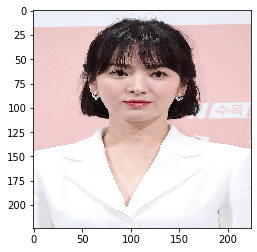

In [8]:
img = Image.open(os.path.join(file_name,"faces/song_hye_kyo.jpg"))
img = img.resize((224,224))
plt.imshow(np.asarray(img))

In [0]:
def pred(model, img, verbose = True):
    imarr = np.array(img).astype(np.float32)
    imarr = np.expand_dims(imarr, axis=0)

    out = model.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    if verbose:
      print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])

    return (best_name[0], out[0,best_index])

### 이상한 결과!!!<br>
인물이 제대로 분류되지 않음...face identification이 제대로 안 됐기 때문

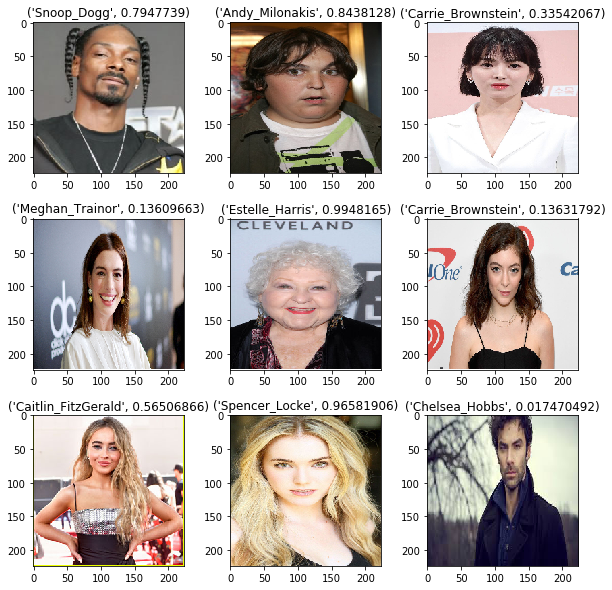

In [10]:
face_list = ["snoop_dogg","andy_milonakis","song_hye_kyo","anne_hathaway","estelle_harris", "lorde",
             "sabrina_carpenter","spencer_locke","aiden_turner"]
fig, axs = plt.subplots(3,3, figsize = (10,10))
fig.subplots_adjust(hspace = .3, wspace = .2)
axs = axs.ravel()

for i in range(9):
  face_path = "faces/"+face_list[i] + ".jpg"
  img = Image.open(os.path.join(file_name, face_path))
  img = img.resize((224,224))
  axs[i].imshow(np.asarray(img))
  axs[i].set_title(str(pred(model, img, verbose = False)))

plt.show()            

### Face Identification

In [0]:
def face_identification(imgpath, verbose = True):
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_default.xml")
  image = cv2.imread(imgpath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,   #이미지에서 얼굴 크기가 서로 다른 것을 보상해주는 값
    minNeighbors=5,    #얼굴 사이 최소 픽셀 값
    minSize=(30,30)   #얼굴 최소 크기
  )
  # faces = faceCascade.detectMultiScale(1.2, 5)

  if verbose:
    print("{0}개 얼굴을 찾았습니다.".format(len(faces)))
    for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.imshow(image)

  return faces

1개 얼굴을 찾았습니다.


array([[182, 163, 408, 408]], dtype=int32)

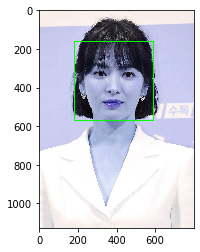

In [12]:
face_identification(os.path.join(file_name, 'faces/song_hye_kyo.jpg'), verbose=True)

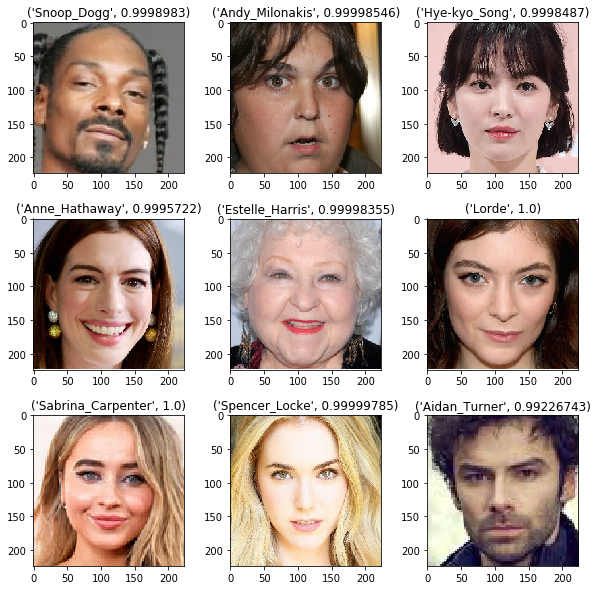

In [13]:
face_list = ["snoop_dogg","andy_milonakis","song_hye_kyo","anne_hathaway","estelle_harris", "lorde",
             "sabrina_carpenter","spencer_locke","aiden_turner"]
fig, axs = plt.subplots(3,3, figsize = (10,10))
fig.subplots_adjust(hspace = .3, wspace = .2)
axs = axs.ravel()

for i in range(9):
  face_path = "faces/"+face_list[i] + ".jpg"
  (x,y,w,h) = face_identification(os.path.join(file_name, face_path), verbose = False)[0]
  img = Image.open(os.path.join(file_name, face_path))
  center_x = x+w/2
  center_y = y+h/2
  b_dim = min(max(w,h)*1.2,img.width, img.height) 
  box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)

  # Crop Image
  crpim = img.crop(box).resize((224,224))
  axs[i].imshow(np.asarray(crpim))
  axs[i].set_title(str(pred(model, crpim, verbose = False)))

plt.show()

### 혹시.... 닮은 꼴 연예인 찾기는 안될까..?

1개 얼굴을 찾았습니다.
866 Hye-kyo_Song 0.48321593 [2.6105403e-07, 0.48321593]


('Hye-kyo_Song', 0.48321593)

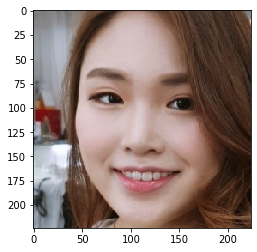

In [18]:
test_path = os.path.join(file_name, 'faces/jookyung.jpg')
test_face = face_identification(test_path, verbose=True)

im = Image.open(test_path)

(x, y, w, h) = test_face[0]
center_x = x+w/2
center_y = y+h/2
b_dim = min(max(w,h)*1.2,im.width, im.height)
box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
crpim = im.crop(box).resize((224,224))
plt.imshow(np.asarray(crpim))

pred(model, crpim)